In [1]:
import psycopg2
from configobj import ConfigObj
import sys
import os
import gdal
import json
import datetime
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)
import json

In [89]:
cfg = ConfigObj("sites/bavaria.site")

with open('cfg/bands.json') as data_file:
    bandcfg = json.load(data_file)


    
conn = psycopg2.connect('postgres://{}:{}@{}/{}'.format(os.environ["POSTGIS_USER"],os.environ["POSTGIS_PASSWORD"],cfg['dbhost'],cfg['dbase']))

In [94]:
from patchfactory import queryDates
import pylab

def queryRaster(conn,rastertable,tiletable, tileid, date, rtype, level, bands):
    curs=conn.cursor()
    # convert band names to band numbers using config file

    sql="""
        select
        	ST_astiff(ST_UNION(ST_CLIP(r.rast, t.geom)),ARRAY{bands})
        from
        	{rastertable} r, {tiletable} t
        where
        	t.id={tileid} and
            ST_INTERSECTS(r.rast,t.geom) and
            r.type='{rtype}' and
            r.level='{level}' and
            date='{date}'
        """.format(rastertable=rastertable,
        tiletable=tiletable,
        tileid=tileid,
        rtype=rtype,
        level=level,
        date=date.strftime("%Y-%m-%d"),
        bands=bands)

    print sql
    # following https://gis.stackexchange.com/questions/130139/downloading-raster-data-into-python-from-postgis-using-psycopg2

    # Use a virtual memory file, which is named like this
    vsipath = '/vsimem/from_postgis'

    # Download raster data into Python as GeoTIFF, and make a virtual file for GDAL
    curs.execute(sql)
    gdal.FileFromMemBuffer(vsipath, bytes(curs.fetchone()[0]))

    # Read first band of raster with GDAL
    ds = gdal.Open(vsipath)
    arrays=[]
    for b in range(len(bands)):
        band = ds.GetRasterBand(b+1)
        arrays.append(band.ReadAsArray())

    # Close and clean up virtual memory file
    ds = band = None
    gdal.Unlink(vsipath)
    curs.close()

    return np.stack(arrays,axis=2)

def queryLabel(conn):
    curs=conn.cursor()
    # convert band names to band numbers using config file

    sql=""" select 
            ST_astiff(
            ST_AddBand(
            st_union(
                st_asraster(st_collect(t.geom,st_intersection(t.geom,l.geom)), 10::float,10::float,'8BUI',l.code::float,0.,st_xmin(t.geom)::float,st_ymax(t.geom)::float)
            ),
            '8BUI'::text, 1, 0)
            )
            from tiles480 t, osm l 
            where t.id=500 and ST_Intersects(t.geom, l.geom)
        """

    print sql
    # following https://gis.stackexchange.com/questions/130139/downloading-raster-data-into-python-from-postgis-using-psycopg2

    # Use a virtual memory file, which is named like this
    vsipath = '/vsimem/from_postgis'

    # Download raster data into Python as GeoTIFF, and make a virtual file for GDAL
    curs.execute(sql)
    gdal.FileFromMemBuffer(vsipath, bytes(curs.fetchone()[0]))

    # Read first band of raster with GDAL
    ds = gdal.Open(vsipath)
    band=ds.GetRasterBand(1)
    arr=band.ReadAsArray()
        
    # Close and clean up virtual memory file
    ds = band = None
    gdal.Unlink(vsipath)
    curs.close()

    return arr

print queryLabel(conn)

def plot(tileid,date,level):
    print date
    
    def m(rtype):

        def toidx(bands):
            return[bandcfg[level][rtype].index(b)+1 for b in bands]

        allbands=bandcfg[level][rtype]
        return queryRaster(conn,rastertable,tiletable, tileid, date, rtype, level, toidx(allbands)),allbands

    arr,bands = m("10m")

    fig,axs=plt.subplots(1,4,figsize=(14,10))
    i=0
    for ax in axs.reshape(-1):
        ax.imshow(arr[:,:,i],interpolation='none')
        ax.set_title(bands[i])
        i+=1

    arr,bands = m("20m")
    fig,axs=plt.subplots(2,3,figsize=(10,6))
    i=0
    for ax in axs.reshape(-1):
        ax.imshow(arr[:,:,i],interpolation='none')
        ax.set_title(bands[i])
        i+=1

    arr,bands = m("60m")
    fig,axs=plt.subplots(1,3,figsize=(9,6))
    i=0
    for ax in axs.reshape(-1):
        ax.imshow(arr[:,:,i],cmap=pylab.gray(),interpolation='none')
        ax.set_title(bands[i])
        i+=1
        
def drawmap(tileid):

    cur=conn.cursor()
    cur.execute("select ST_asgeojson(ST_Transform(geom,4326)) from {} where id={};".format(tiletable,tileid))
    geojson = json.loads(cur.fetchone()[0])
    cur.close()

    lon,lat = geojson["coordinates"][0][0]
    center = [lat,lon]
    zoom = 13

    g = GeoJSON(data=geojson)

    m = Map(center=center, zoom=zoom)

    m.add_layer(g)
    return m

 select 
            ST_astiff(
            ST_AddBand(
            st_union(
                st_asraster(st_collect(t.geom,st_intersection(t.geom,l.geom)), 10::float,10::float,'8BUI',l.code::float,0.,st_xmin(t.geom)::float,st_ymax(t.geom)::float)
            ),
            '8BUI'::text, 1, 0)
            )
            from tiles480 t, osm l 
            where t.id=500 and ST_Intersects(t.geom, l.geom)
        
[[33 33 33 ..., 33 33 33]
 [33 33 33 ..., 33 33 33]
 [33 33 33 ..., 33 33 33]
 ..., 
 [33 33 33 ..., 33 33 33]
 [33 33 33 ..., 33 33 33]
 [33 33 33 ..., 33 33 33]]


 select 
            ST_astiff(
            ST_AddBand(
            st_union(
                st_asraster(st_collect(t.geom,st_intersection(t.geom,l.geom)), 10::float,10::float,'8BUI',l.code::float,0.,st_xmin(t.geom)::float,st_ymax(t.geom)::float)
            ),
            '8BUI'::text, 1, 0)
            )
            from tiles480 t, osm l 
            where t.id=500 and ST_Intersects(t.geom, l.geom)
        


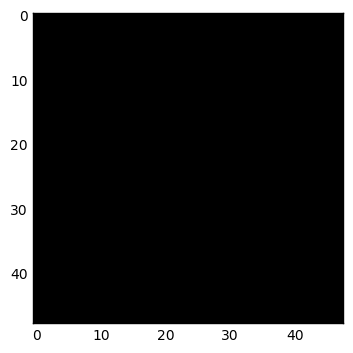

In [97]:
arr = queryLabel(conn)
plt.imshow(arr)

2016-08-07

        select
        	ST_astiff(ST_UNION(ST_CLIP(r.rast, t.geom)),ARRAY[1, 2, 3, 4])
        from
        	bavaria r, tiles480 t
        where
        	t.id=6000 and
            ST_INTERSECTS(r.rast,t.geom) and
            r.type='10m' and
            r.level='L1C' and
            date='2016-08-07'
        

        select
        	ST_astiff(ST_UNION(ST_CLIP(r.rast, t.geom)),ARRAY[1, 2, 3, 4, 5, 6])
        from
        	bavaria r, tiles480 t
        where
        	t.id=6000 and
            ST_INTERSECTS(r.rast,t.geom) and
            r.type='20m' and
            r.level='L1C' and
            date='2016-08-07'
        

        select
        	ST_astiff(ST_UNION(ST_CLIP(r.rast, t.geom)),ARRAY[1, 2, 3])
        from
        	bavaria r, tiles480 t
        where
        	t.id=6000 and
            ST_INTERSECTS(r.rast,t.geom) and
            r.type='60m' and
            r.level='L1C' and
            date='2016-08-07'
        


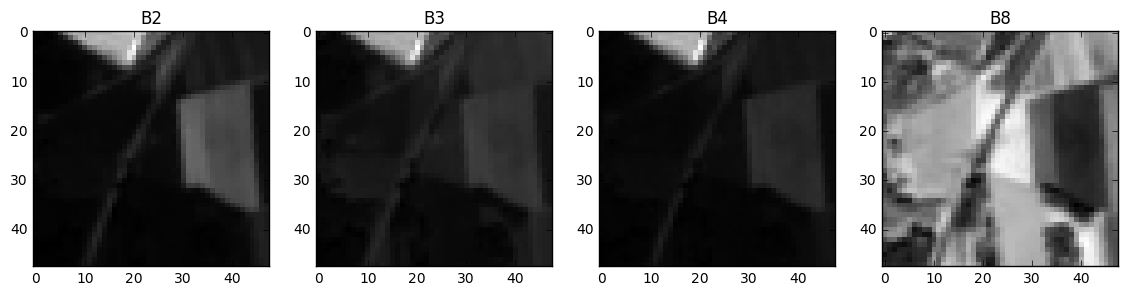

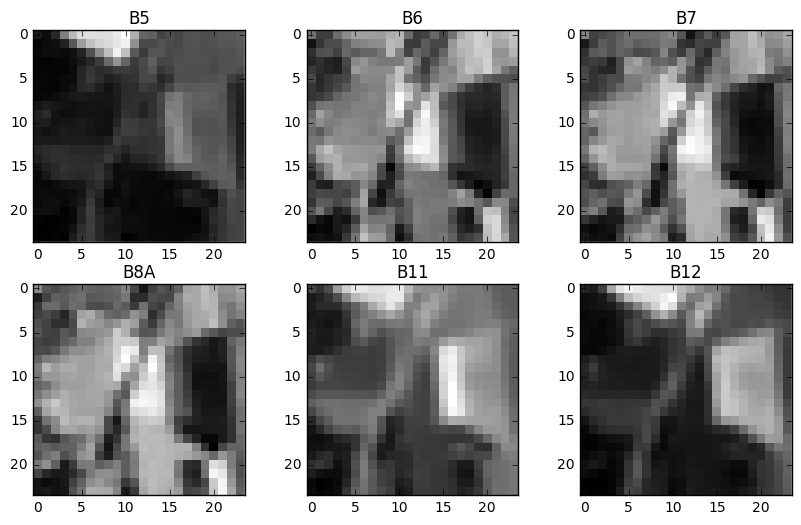

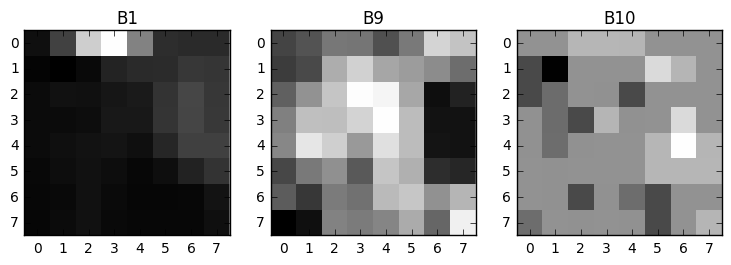

In [73]:
dates = queryDates(conn,"bavaria")["date"].sort_values().values

level='L1C'
rastertable="bavaria"
tiletable="tiles480"

tileid=6000

plot(tileid,dates[20],level)

In [79]:
drawmap(tileid)

Map(center=[48.5940542061808, 11.2801288764834], layers=(TileLayer(options=[u'opacity', u'attribution', u'max_zoom', u'detect_retina', u'min_zoom', u'tile_size']), GeoJSON(data={u'type': u'Polygon', u'coordinates': [[[11.2801288764834, 48.5940542061808], [11.2803231559197, 48.5983689825533], [11.2738179499295, 48.598497676363], [11.2736242235593, 48.5941828805843], [11.2801288764834, 48.5940542061808]]]})), layout=Layout(align_self=u'stretch', height=u'400px'), options=[u'keyboard_pan_offset', u'tap', u'attribution_control', u'max_zoom', u'min_zoom', u'bounce_at_zoom_limits', u'keyboard', u'scroll_wheel_zoom', u'dragging', u'inertia_max_speed', u'close_popup_on_click', u'zoom_control', u'box_zoom', u'double_click_zoom', u'tap_tolerance', u'zoom_start', u'keyboard_zoom_offset', u'inertia_deceleration', u'inertia', u'center', u'zoom', u'world_copy_jump', u'zoom_animation_threshold', u'touch_zoom'], zoom=13)

In [77]:
dates = queryDates(conn,"bavaria")["date"].sort_values()

In [78]:
dates

17    2016-01-03
4     2016-01-13
13    2016-01-20
43    2016-02-12
45    2016-03-11
28    2016-03-20
36    2016-04-03
18    2016-04-13
3     2016-04-19
38    2016-04-29
2     2016-05-02
33    2016-05-10
32    2016-05-22
31    2016-06-08
41    2016-06-28
6     2016-07-14
11    2016-07-18
30    2016-07-21
16    2016-07-28
1     2016-07-30
25    2016-08-07
35    2016-08-17
40    2016-08-20
27    2016-08-28
5     2016-08-31
9     2016-09-08
44    2016-09-12
19    2016-09-26
22    2016-09-29
34    2016-10-09
26    2016-10-18
12    2016-10-28
23    2016-11-15
15    2016-12-06
10    2016-12-08
46    2017-01-27
8     2017-02-13
42    2017-02-16
20    2017-02-23
29    2017-03-25
21    2017-03-28
14    2017-04-07
37    2017-04-24
39    2017-05-04
24    2017-05-14
7     2017-05-17
0           None
Name: date, dtype: object

In [34]:
conn.close()